# Stochastic Optimization with Heavy-Tailed Noise via Accelerated Gradient Clipping

### 1. Постановка задачи

$$\min_{x \in \mathbb{R}^n}f(x), \quad f(x) = \mathbb{E}_{\xi}[f(x, \xi)],$$
где $f(x)$
  - выпуклая
  - гладкая
  - $\forall x \in \mathbb{R}^n \rightarrow \exists \nabla f(x, \xi): \mathbb{E}_{\xi}[\nabla f(x, \xi)] = \nabla f(x), \quad \mathbb{E}_{\xi}[\|\nabla f(x, \xi) - \nabla f(x)\|^2_2] \leq \sigma^2$


### 2. Идея статьи

Результатом статьи является представление 2 новых алгоритмов - **"Clipped Stochastic Similar Triangles Method (clipped-SSTM)"** и **"SGD with Clippin"**. Суть, которых заключается [TO DO]

### 3. Теоретические результаты

### 4. Суть доказательства

### Экспериментальная часть

Реализуем основные методы. В статье представлены измененные варианты SGD и SSTM (обратите внимание на парметр clipped в функциях).

In [1]:
import numpy as np
from numpy.linalg import norm

import scipy.stats as sps
from scipy.sparse.linalg import svds
from scipy.optimize import minimize

import copy

from sklearn.datasets import load_svmlight_file

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="darkgrid")

In [2]:
def SGD(f, grad_f, x_0, stepsize, number_its,
        distribution_rvs, batch, clipped, clipping_level, **args_distribution):
    """
        f - функция, минимум которой ищем
        grad_f - градиент f
        
        x_0 - начальная точка
        stepsize - размер шага > 0
        number_its - количество итераций
        
        distribution_rvs - генерация величин из какого-то распределения. Ожидаются функции из sps
        
        clipped - метод использует обрезанный градиент или нет
        clipping_level (если clipped == False, то установите произвольным) > 0
    """
    info = [f(x_0)]
    for k in range(number_its):
        xi = distribution_rvs(size=batch, **args_distribution)
        grad = grad_f(x_0, xi)
        if clipped:
            x_0 = x_0 - stepsize * min(1, clipping_level / norm(grad)) * grad
        else:
            x_0 = x_0 - stepsize * grad
        info.append(f(x_0))
    return (x_0, info)

In [3]:
def SSTM(f_grad, x_0, stepsize, number_its, L, clipping_param_B,
         batch, f_metric, distribution_rvs, clipped, **args_distribution):
    """
        f_grad - градиент f. Функция от двух параметров x, xi
        f_metric - метрика сходимости f(для построения графика). Функция от одного параметра x
        
        x_0 - начальная точка
        stepsize - размер шага > 0
        number_its - количество итераций
        L - константа Липшица функции f
        
        distribution_rvs - генерация величин из какого-то распределения. Ожидаются функции из sps
        
        clipped - метод использует обрезанный градиент или нет
        clipping_param_B - параметр клиппинга (если clipped == False, то установите произвольным)
    """
    y_0 = copy.deepcopy(x_0)
    z_0 = copy.deepcopy(x_0)
    A_0 = 0

    info = [f_metric(y_0)]
    
    for k in range(number_its):
        alpha = (k + 2) / (2 * stepsize * L)
        A_dop = A_0 + alpha
        x_0 = (A_0 * y_0 + alpha * z_0) / A_dop
        
        batch_ind = distribution_rvs(size=batch, **args_distribution)
        grad = f_grad(x_0, batch_ind)
        
        if clipped:
            clipping_level = clipping_param_B / alpha
            z_0 = z_0 - alpha * min(1, clipping_level / norm(grad)) * grad
        else:
            z_0 = z_0 - alpha * grad

        y_0 = (A_0 * y_0 + alpha * z_0) / A_dop
        A_0 = copy.deepcopy(A_dop)
        
        info.append(f_metric(y_0))
    
    return (y_0, info)

Для дальнейшей работы также понадобиться функция для отрисовки графиков.

In [4]:
def CreatePlot(data_metods, labels, title):
    plt.figure(figsize=(12, 8))
    plt.yscale('log')
    
    for i in range(len(data_metods)):
        plt.plot(np.arange(len(data_metods[i])), data_metods[i], label=labels[i])
    plt.title(title)
    plt.legend()

### 5. Эксперименты из статьи

#### 5.1 Сlipped SGD

В этой части мы реализуем алгоритм Сlipped SGD и повторим эксперименты из секции 1.2 (H1 полной статьи).

Рассмотрим функцию $$f(x, \xi) = \frac{\|x\|_2^2}{2} + \langle \xi, x \rangle,$$
где $\xi$ - случайная величина с матожиданием 0 и дисперсией $\sigma^2 = 1$.

Будут изучены 3 распределения.

1. Norm
2. Weibull distribution
3. Burr Type XII distribution

Для всех распределений установим параметры:
 - $\gamma = 0.001$ - размер шага
 - $n = 100$ - размерность x
 - $\lambda = 100$ - уровень клиппинга

In [13]:
def f(x):
    return 0.5 * (norm(x))**2

def grad_f(x, xi):
    return x + xi

def CreatePlot(info_sgd, info_csgd, title):
    plt.figure(figsize=(10, 6))
    plt.yscale('log')
    plt.plot(np.arange(len(info_sgd)), info_sgd, label="sgd", c='green')
    plt.plot(np.arange(len(info_csgd)), info_csgd, label="csgd", c='red')
    plt.title(title)
    plt.legend()

Для нормального распределения уставновим $a = 0, \sigma = 1$.

In [5]:
x_csgd, info_csgd = SGD(f, grad_f, 
                        0.01 * np.array(range(100)), # x_0
                        0.001, # stepsize
                        100000, # number_its
                        sps.norm.rvs, # distribution_rvs
                        100, # batch
                        True, # clipped
                        100, # clipping_level
                        loc=0, scale=1)

x_sgd, info_sgd = SGD(f, grad_f, 
                        0.01 * np.array(range(100)), # x_0
                        0.001, # stepsize
                        100000, # number_its
                        sps.norm.rvs, # distribution_rvs
                        100, # batch
                        False, # clipped
                        100, # clipping_level
                        loc=0, scale=1)

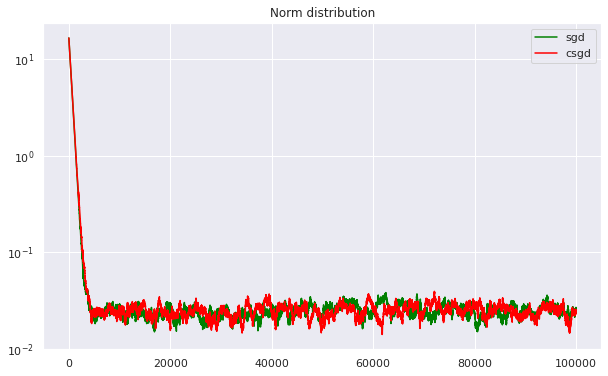

In [6]:
CreatePlot(info_sgd, info_csgd, "Norm distribution")

Пусть теперь $\xi$ ~ $W(c, \alpha)$

$$E\xi = \alpha Г(1 + \frac{1}{c})$$
$$D\xi = \alpha^2 (Г(1 + \frac{2}{c}) - (Г(1 + \frac{2}{c}))^2)$$

Тогда, чтобы распределение обладало нужными свойствами, возьмем
- $с = 0.2$
- $\alpha = \frac{1}{\sqrt{Г(1 + \frac{2}{c}) - (Г(1 + \frac{2}{c}))^2}}$

In [7]:
c = 0.2
scale = 1 / np.sqrt(scipy.special.gamma(1 + 2 / c) - ((scipy.special.gamma(1 + 1 / c))**2))
loc = -scale * scipy.special.gamma( 1 + 1 / c)

In [8]:
x_csgd, info_csgd = SGD(f, grad_f, 
                        0.01 * np.array(range(100)), # x_0
                        0.001, # stepsize
                        100000, # number_its
                        sps.weibull_min.rvs, # distribution_rvs
                        100, # batch
                        True, # clipped
                        100, # clipping_level
                        c=0.2, loc=loc, scale=scale)

x_sgd, info_sgd = SGD(f, grad_f, 
                      0.01 * np.array(range(100)), # x_0
                      0.001, # stepsize
                      100000, # number_its
                      sps.weibull_min.rvs, # distribution_rvs
                      100, # batch
                      False, # clipped
                      100, # clipping_level
                      c=0.2, loc=loc, scale=scale)

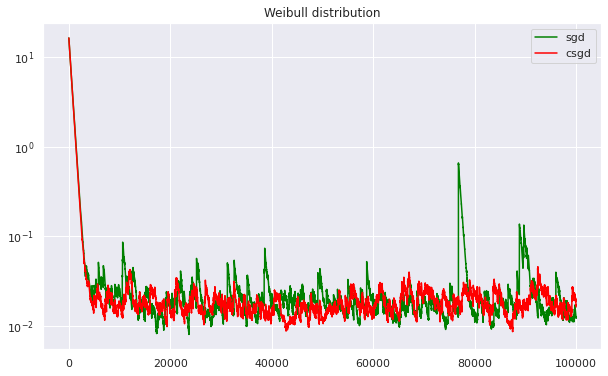

In [9]:
CreatePlot(info_sgd, info_csgd, "Weibull distribution")

Пусть теперь $\xi$ ~ $Burr(c, d)$

$$E\xi^k = d B(\frac{cd - k}{c}, \frac{c + k}{c})$$

Тогда, чтобы распределение обладало нужными свойствами, возьмем
- $с = 1$
- $d = 2.3$

In [10]:
c = 1.0
d = 2.3

first_moment = d * scipy.special.beta((c * d - 1) / c, (c + 1) / c)
second_moment = d * scipy.special.beta((c * d - 2) / c, (c + 2) / c)

scale = 1 / np.sqrt(second_moment - first_moment**2)
loc = -scale * first_moment

x_csgd, info_csgd = SGD(f, grad_f, 
                        0.01 * np.array(range(100)), # x_0
                        0.001, # stepsize
                        100000, # number_its
                        sps.burr12.rvs, # distribution_rvs
                        100, # batch
                        True, # clipped
                        100, # clipping_level
                        c=c, d=d, loc=loc, scale=scale)

x_sgd, info_sgd = SGD(f, grad_f, 
                      0.01 * np.array(range(100)), # x_0
                      0.001, # stepsize
                      100000, # number_its
                      sps.burr12.rvs, # distribution_rvs
                      100, # batch
                      False, # clipped
                      100, # clipping_level
                      c=c, d=d, loc=loc, scale=scale)

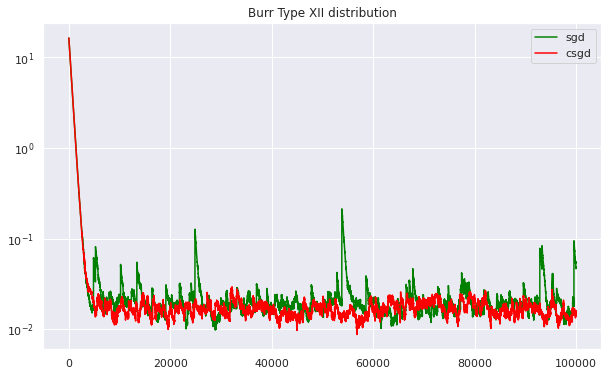

In [11]:
CreatePlot(info_sgd, info_csgd, "Burr Type XII distribution")

**Вывод:**

####  5.2 Clipped Stochastic Similar Triangles Method

В данной части будем рассматривать логистическую регрессию

$$\min_{x \in \mathbb{R}^n} f(x) = \frac{1}{r} \sum_{i = 1}^r log(1 + exp(-y_i (Ax)_i)),$$

$A \in \mathbb{R}^{r×n}$,  $y \in \{0, 1\}^r$.

In [5]:
def f(x, y, A):
    return np.sum(np.log(1 + np.exp(-(A @ x) * y))) / y.shape[0]

def f_grad(x, y, A):
    return  -A.T @ (y * np.exp(-(A @ x) * y) / (1 + np.exp(-(A @ x) * y))) / y.shape[0]

Для данной функции мы знаем константу липшица:

$$L = \frac{\lambda_{max}(A^TA)}{4r}$$

В качестве датасетов будут использованы `heart`, `diabetes`, `australian`, `a9a`, `w8` из `LIBSVM`. Гиперпараметры следующие:

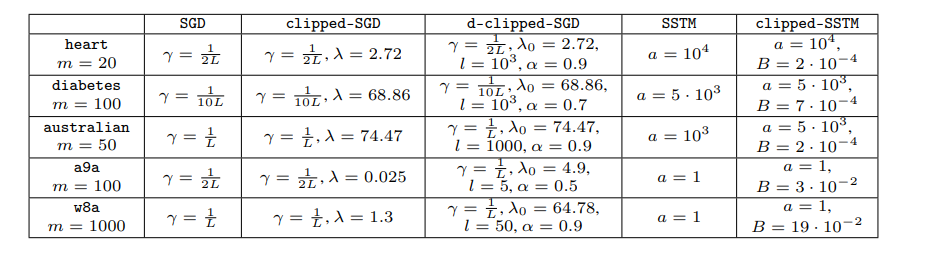

In [13]:
def create_data(data_name, m, lambda_, a, B):
    # загружаем данные
    A, y = load_svmlight_file(data_name)
    
    # ищем константу липшица
    L = svds(A.T @ A, return_singular_vectors=False).max() / (4 * A.shape[0])
    
    # находим минимум функции (для метрики)
    res = minimize(lambda x: f(x, y, A),
                   np.zeros(A.shape[1]),
                   jac=lambda x: f_grad(x, y, A),
                   method='L-BFGS-B')
    f_star = res.fun
    x_star = res.x
    
    # смотрим на сходимость разных методов
    fcsstm = SSTM(lambda x, xi: f_grad(x, y[xi], A[xi]), # f_grad
           x_star + 0.1, # x_0
           a, # stepsize
           300000, # number_its
           L, # L
           B, # clipping_param_B
           m, # batch_size
           lambda x: f(x, y, A) - f_star, # f_metric
           sps.randint.rvs, # distribution_rvs
           True, # clipped
           low=0,
           high=A.shape[0]
           )[1]
    
    print("Successfully completed Clipped sstm")

    fsstm = SSTM(lambda x, xi: f_grad(x, y[xi], A[xi]), # f_grad
               x_star + 0.1, # x_0
               a, # stepsize
               300000, # number_its
               L, # L
               B, # clipping_param_B
               m, # batch_size
               lambda x: f(x, y, A) - f_star, # f_metric
               sps.randint.rvs, # distribution_rvs
               False, # clipped
               low=0,
               high=A.shape[0]
               )[1]
    
    print("Successfully completed sstm")
    
    
    return (fcsstm, fsstm)

In [14]:
fcsstm, fsstm = create_data("heart.txt", 20, 2.72, 10**4, 2 * 10**(-4))

Successfully completed Clipped sstm
Successfully completed sstm


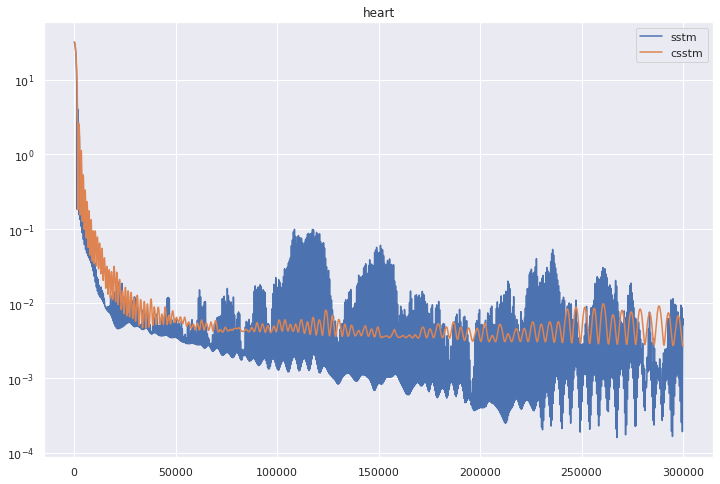

In [15]:
CreatePlot([fsstm, fcsstm], ['sstm', 'csstm'], "heart")

**Вывод:**

### 6. Собственные эксперименты

###  Дополнительно

#### Базовая терминология

**Опр.** Пусть дана непрерывно дифференцируемая на $\mathbb{R}^n$ функция $ f(x) : \mathbb{R}^n \longrightarrow \mathbb{R} $ . Будем говорить, что она является **выпуклой**, если для любых x, y $\in \mathbb{R}^n$ выполнено
$$f(y) \geq f(x) + \langle \nabla f(x), y - x \rangle$$

**Опр.** Пусть дана непрерывно дифференцируемая на $\mathbb{R}^n$ функция  $ f(x) : \mathbb{R}^n \longrightarrow \mathbb{R} $. Будем говорить, что данная функция имеет L-Липшицев градиент (говорить, что она является **L-гладкой**), если для любых x, y $\in \mathbb{R}^n$ выполнено

$$\|\nabla f(x) - \nabla f(y)\|_2 \leq L\|x - y\|_2$$

**Опр.** Случайный вектор $\xi$ принадлежит **распределению с легкими хвостами**, если
  1. $\mathbb{E}[\xi]$
  2. $\forall b > 0 \rightarrow \mathbb{P}\{\|\xi - \mathbb{E}[\xi]\|_2 > b\} \leq 2 exp(-\frac{b^2}{2\sigma^2})$ 

Что эквивалентно условию [1]

$$\mathbb{E}[exp(\|\xi - \mathbb{E}[\xi]\|_2^2 / {\sigma^2})] \leq exp(1)$$

#### Ссылки на источники

[0] Stochastic Optimization with Heavy-Tailed Noise via Accelerated Gradient Clipping (Eduard Gorbunov, Marina Danilova, Alexander Gasnikov)

[1] Лемма 2, Chi Jin, Praneeth Netrapalli, Rong Ge, Sham M Kakade, and Michael I Jordan. A short
note on concentration inequalities for random vectors with subgaussian norm. arXiv preprint
arXiv:1902.03736, 2019